In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
%matplotlib inline

In [2]:
data = pd.read_csv('./全部数据/附件1-区域15分钟负荷数据.csv', parse_dates=['数据时间'], index_col=[0])
data

,总有功功率（kw）
数据时间,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269
...,...
2021-08-31 22:45:00,202409.1270
2021-08-31 23:00:00,218576.4635
2021-08-31 23:15:00,200112.5091


In [3]:
# data中时间序列不连续，本来有128544行，但是data只有128156行
# 用重采样的方式将有断点的时间序列变成连续时间序列
data_fill = data.resample('15T').mean()
# 用中位数填充空缺值
data_fill[data_fill.isna().iloc[:,0]] = data.median()

In [4]:
data_fill

,总有功功率（kw）
数据时间,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269
...,...
2021-08-31 22:45:00,202409.1270
2021-08-31 23:00:00,218576.4635
2021-08-31 23:15:00,200112.5091


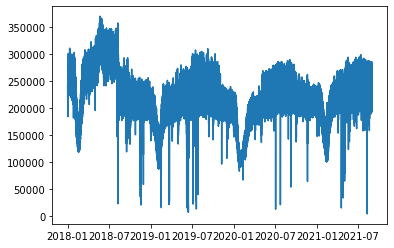

In [5]:
plt.plot(data_fill)

In [6]:
# 用原数据减去滑动平均数据的方法，求出波动图，再通过箱型图的方法将异常数据赋值为np.NaN
# prophet会根据插值的方法自动填充np.NaN值
def drop_outlier(data1, column, window=15):
    data_smooth = data1.iloc[:,column].rolling(window, center=True).mean()
    
    # 用滑动窗口给data_smooth数据两边各有window//2个的np.NaN值填充
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data1.iloc[j,column]
        data_smooth[i] = sum / (i+1)
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data1.iloc[len(data_smooth) - j - 1, column]
        data_smooth[len(data_smooth) - i - 1] = sum / (i+1)
    
    data_sub = data1.iloc[:,column] - data_smooth
    
    q1 = data_sub.quantile(0.25)
    q3 = data_sub.quantile(0.75)
    
    # 分别为箱线图的上界和下界
    upper_whisker = q3 + 1.5*(q3-q1)
    lower_whisker = q1 - 1.5*(q3-q1)

    rule = (lower_whisker > data_sub) | (upper_whisker < data_sub)
    
    data_drop_outlier = data1.copy()
    data_drop_outlier.loc[rule, data_drop_outlier.columns[column]] = np.NaN
    
    return data_drop_outlier

In [21]:
def FB(data1, column):
    df = pd.DataFrame({
        'ds': pd.Series(data1.iloc[:,column].index),
        'y': pd.Series(data1.iloc[:,column].values)
        })
    df['cap'] = data1.iloc[:,column].max()
    df['floor'] = data1.iloc[:,column].min()
    
    m = Prophet(
        changepoint_prior_scale=0.05, 
        daily_seasonality=False,
        yearly_seasonality=True, #年周期性
        weekly_seasonality=True, #周周期
        growth="linear",
        interval_width=0.8 #置信区间宽度，有多大概率落在浅蓝色线里

    )

    m.add_country_holidays(country_name='CN')#中国所有的节假日    

    m.fit(df)

    future = m.make_future_dataframe(periods=91, freq='D')
    future['cap'] = data1.iloc[:,column].max()
    future['floor'] = data1.iloc[:,column].min()

    forecast = m.predict(future)

    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)
    return future, forecast

In [25]:
# 将每天96个时间点的数据减去该天功率的平均数数据，使所有点的的功率变化都在一条水平线上
data_day_mean = data_fill.resample('D').mean().values
data_values = [data_fill.iloc[i + 96*j, 0] - data_day_mean[j][0] for j in range(1339) for i in range(96)]

In [26]:
# 利用正态分布的3σ原则，得出异常点数目为472
data_values = pd.Series(data_values)
mean = data_values.mean()
std = data_values.std()
rule=(mean-3*std > data_values) | (mean+3*std < data_values)
rule.sum()

362

In [36]:
# 先用中位数填充异常点，使异常点落在大部分取值范围中
data_del_wrong = data_values.copy()
data_del_wrong[rule] = data_values.median()

# 再用滑动平均数去给异常点赋值，使异常点的数值与周围10个点的数值连续
data_del_wrong[rule] = pd.Series(data_del_wrong).rolling(10, center=True).mean()[rule]
data_smooth = pd.DataFrame(data_del_wrong.values, index=data_fill.index)

In [37]:
data_smooth

,0
数据时间,
2018-01-01 00:00:00,20632.702162
2018-01-01 00:15:00,9319.574162
2018-01-01 00:30:00,8284.623062
2018-01-01 00:45:00,4180.265662
2018-01-01 01:00:00,10081.360862
...,...
2021-08-31 22:45:00,-26997.446417
2021-08-31 23:00:00,-10830.109917
2021-08-31 23:15:00,-29294.064317


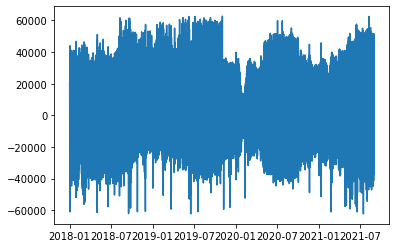

In [38]:
plt.plot(data_smooth)

In [42]:
def FB_day(data1, column):
    df = pd.DataFrame({
        'ds': pd.Series(data1.iloc[:,column].index),
        'y': pd.Series(data1.iloc[:,column].values)
        })
    df['cap'] = data1.iloc[:,column].max()
    df['floor'] = data1.iloc[:,column].min()
    
    m = Prophet(
        changepoint_prior_scale=0.05, 
        daily_seasonality=True,
        yearly_seasonality=False, #年周期性
        weekly_seasonality=False, #周周期
        growth="linear",
        interval_width=0.8 #置信区间宽度，有多大概率落在浅蓝色线里

    )

    # m.add_country_holidays(country_name='CN')#中国所有的节假日    

    m.fit(df)

    future = m.make_future_dataframe(periods=91*96, freq='15T')
    future['cap'] = data1.iloc[:,column].max()
    future['floor'] = data1.iloc[:,column].min()

    forecast = m.predict(future)

    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)
    return future, forecast

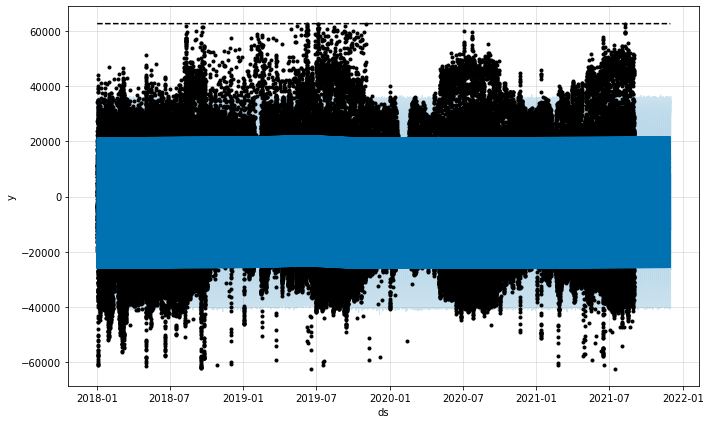

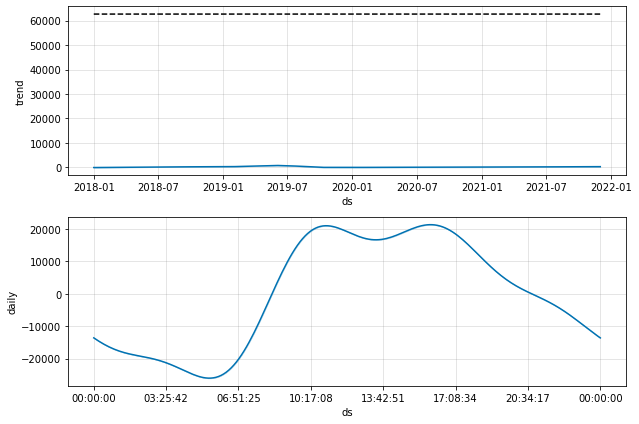

In [44]:
future, forecast = FB_day(data_smooth, 0)

In [79]:
day = pd.Series(forecast.daily.values[-96:], index=pd.date_range('2021-11-30', periods=96, freq='15T'))

In [88]:
day.values.max()

21245.586701826585

In [93]:
# true值在第65个
[day.values == day.values.max()]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False])]

In [97]:
# true值在第23个，说明在每天的5:45分取得最小值
day.values == day.values.min()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

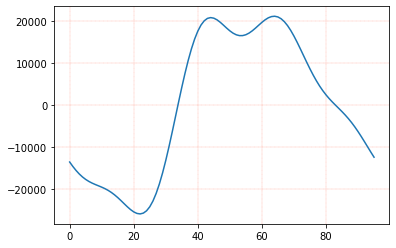

In [98]:
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(day.values)